<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/firstTryDraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **First Approach**

After performing our [EDA](https://github.com/jjordana/twitter_sentiment_analysis/blob/master/EDA.ipynb), our next step is going to be to try to achieve some of the target data (_selected_text_).<br>
We will be using the previous output data.


## Importin Data, Libraries & More

In [209]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import collections

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet') # For the counterPlots
nltk.download('vader_lexicon') # For the counterPlots

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

We can check that we have all the data comming from the previous notebook. However,  we are going to remove the columns corresponding to the `jaccScore`, `polarityScore` and `subjectivity`.



In [211]:
train = train.drop(columns=['Unnamed: 0', 'jaccScore', 'polarityScore', 'subjectivity'])
print(train['sentiment'].value_counts())
train.head()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


,textID,text,selected_text,sentiment,newText,newSelection
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i`d have responded if i were going,i`d have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,so sad
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldn`t they put them on the re...,sons of


We know that our dataset is a little bit `imbalanced`. This casuistics usually give us some difficulties when we try to solve it with the common algorightms. Tipical algorithms tend to focus towards the majority class, and they often do not considerate the data distribution. A good solution to deal this issue is to `oversample` or `undersample` each class. <br>
Nevertheless, as this is our first try, we are not going to change anything, just to see what happens.

In most of NLP processes, tokenization and lemmatization is a must. Therefore, let's go ahead with them. <br>
We are going to tokenize and lemmatize either the raw data (the one comming from the [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction)) and the traeted data _newText_ and _newSelection_ (result of cleaning all the not desired characters and applying a previous lemmatization).

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in str(text).lower().split(" ") if token != "" if token not in STOPWORDS]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [0]:
# Raw Data
train['textToken'] = train['text'].apply(tokenization)
train['selectedTextToken'] = train['selected_text'].apply(tokenization)
train['textToken'] = train['textToken'].apply(lemmatization)
train['selectedTextToken'] = train['selectedTextToken'].apply(lemmatization)

# Treated Data
train['newTextToken'] = train['newText'].apply(tokenization)
train['newSelectedTextToken'] = train['newSelection'].apply(tokenization)
train['newTextToken'] = train['newTextToken'].apply(lemmatization)
train['newSelectedTextToken'] = train['newSelectedTextToken'].apply(lemmatization)

How similar are our `selected_text` and `newSelecttion` tokens?<br>
Let's plot a simple graph to have an idea comparing their jaccard score.

In [0]:
def jaccardScore(a, b):  
  try:
    intersect = list(set(a).intersection(b)) # Common values between A and B
    union = len(a) + len(b) - len(intersect) # Values of A and B witout commons
    return round((len(intersect) / union), 2)
  except: # For those cases in which our tweet is mainly composed of STOPWORDS
    return 1

In [0]:
train['jaccScore'] = train.apply(lambda x: jaccardScore(x.selectedTextToken, x.newSelectedTextToken), axis=1)

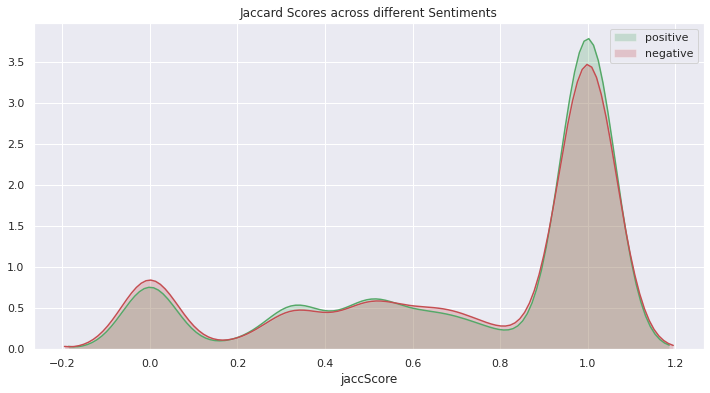

In [216]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)

plt.legend(labels=['positive','negative'])

Interesting.<br>
We can see that the jaccar score is well distributed, but in any case it behaves in the same way for positive and negative tweets. <br>
Besides, is seems that in the majority of the cases our `newSelection` and `selection_text` have a high similarity.

If we plot also neutral tweets, we can see that it's behavour is more arbitrary.

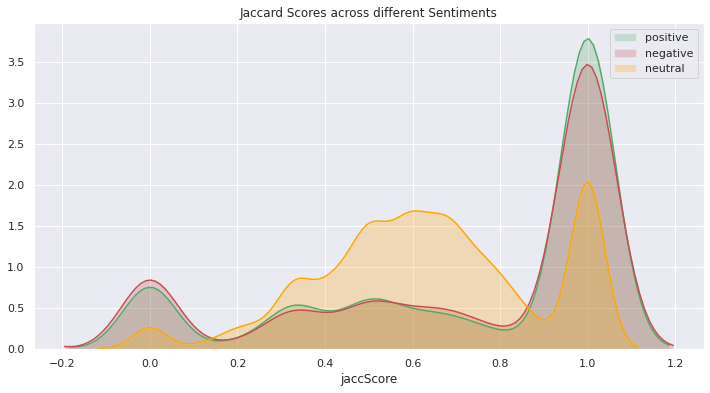

In [217]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)
p2=sns.distplot(train[train['sentiment']=='neutral']['jaccScore'], kde_kws={"shade": True}, color="orange", hist=False)


plt.legend(labels=['positive','negative', 'neutral'])

We are going to try to get all the selected_words just using our tokens. <br>
As we saw before, there is an interesting score value called `polarity_score`. It gives information about how positive, neutral or negative is a word. Besides, there is another metric `compound` which merges all the weights for the given word. 

By calculating our polarity score we might be able to achieve some kind of good result.<br>
Firstly, we will tokenize our raw text __maintaning the STOPWORDS__. This time we want to keep all the data.<br>
Secondly, we will divide our study in three main parts. The division will be performed by sentiment. As we have seen before, neutral sentiment tweets behave randomyl. Therefore we must analyze them separetly.

In [0]:
df = train[['text', 'selected_text', 'sentiment', 'newText', 'newSelection']]

In [0]:
class TweetPreparation():
  def __init__(self, dataframe, rawText, tokens, newSelection):
    self.df = dataframe
    self.rawText = rawText
    self.tokens = tokens
    self.newSelection = newSelection

  def tokenization(self, n_gram=1):
    token = [token for token in str(self.df[self.rawText]).lower().split(" ") if token != ""]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

  def sentiment_analyzer_scores(self):
    scores = []
    for word in self.tokens:
      score = sid.polarity_scores(str(word))
      score = score['compound']
      scores.append(score)
    return scores

  def result(self):
    self.df['token'] = self.df[self.rawText].apply(tokenization)
    self.df['tokenScore'] = self.df['token'].apply(sentiment_analyzer_scores)
    self.df['tokenLen'] = self.df['token'].apply(len)

    self.df['selectedToken'] = self.df[self.newSelection].apply(tokenization)
    self.df['selectedLen'] = self.df['selectedToken'].apply(len)
    return self.df

In [0]:
data = TweetPreparation(dataframe=df, rawText='text', tokens='tokens', newSelection='newSelection')

In [221]:
df = data.result()
df

,text,selected_text,sentiment,newText,newSelection,token,tokenScore,tokenLen,selectedToken,selectedLen
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i`d have responded if i were going,i`d have responded if i were going,"[i`d, responded,, going]","[0.0, 0.0, 0.0]",3,"[i`d, responded, going]",3
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,so sad,"[sooo, sad, will, miss, san, diego!!!]","[0.0, -0.4767, 0.0, -0.1531, 0.0, 0.0]",6,[sad],1
2,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me,"[boss, bullying, me...]","[0.0, -0.5994, 0.0]",3,[bullying],1
3,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone,"[interview!, leave, alone]","[0.0, -0.0516, -0.25]",3,"[leave, alone]",2
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldn`t they put them on the re...,sons of,"[sons, ****,, couldn`t, put, releases, already...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,[sons],1
...,...,...,...,...,...,...,...,...,...,...
27475,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband l...,d lost,"[wish, come, see, u, denver, husband, lost, jo...","[0.4019, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3182, 0.0...",10,"[d, lost]",2
27476,I`ve wondered about rake to. The client has ...,", don`t force",negative,i`ve wondered about rake to the client has m...,don`t force,"[i`ve, wondered, rake, to., client, made, clea...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3818, 0.0, 0....",17,"[don`t, force]",2
27477,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you...,yay good for both of you,"[yay, good, you., enjoy, break, -, probably, n...","[0.5267, 0.4404, 0.0, 0.4939, 0.0, 0.0, 0.0, 0...",14,"[yay, good]",2
27478,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,but it was worth it,"[worth, ****.]","[0.2263, 0.0]",2,[worth],1


For each token we want to calculate its polarity score. 
If the tweet is positive or negative, we will focus on those scores that have the highest value. That value would be key for determining from where do we start getting our first seelcted word. With neutral tweets it will be more complicated.

However, how do we know how many words do we need to get? This is difficult to answer.<br>
For the moment, we will try to plot if there is any realtion between the `selected_text` and the `text` lengths. 

### Positive

In [0]:
df1 = df[df.sentiment=='positive']

In [0]:
df2 = df1.groupby(['tokenLen'])['tokenLen','selectedLen'].mean()

Text(0.5, 1.0, 'Tweet length V.S. selected_text mean')

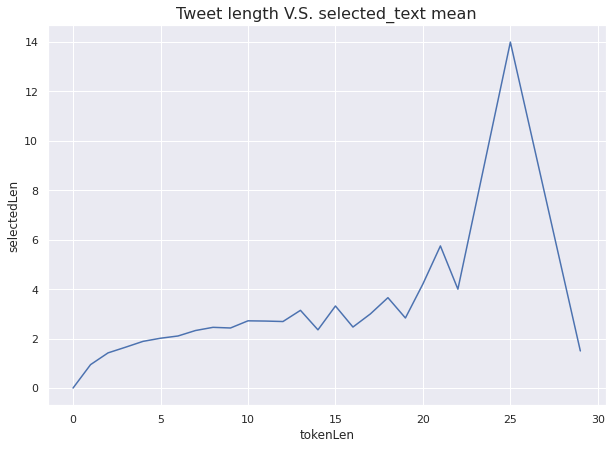

In [224]:
my_palette = sns.color_palette("muted")
sns.set(rc={'figure.figsize':(10, 7)})
sns.lineplot(x='tokenLen', y="selectedLen", data=df2, palette=my_palette) .set_title('Tweet length V.S. selected_text mean', fontsize=16)

For each different length of out tweets, we have calculated the mean value of the selected text. This is crucial to know how many words should we take. For example, tweets with 15 tokens have a mean of 4 words in their __selected_test__. This can be helptful in our selection.

We have the `polarity_score` for each of our tokens in our tweet. Let's try to get the key words.<br>
Through the function `decider` we: get the maximum score in our set of tokens (we suposse that this will be the key word). Then, through the calculus of the mean for the current tweet lenght, we will get all the words.<br>
The result must be checked with the selected_text to see if finally we have end up with something. 

In [0]:
def decider(tokensScore, tokenLen, token):
  #tokenScore: polarity of each token from our tweet.
  #tokenLen: length of our token
  values = tokensScore
  print(token)
  # if sentiment == 'positive':
  #   values = [item for item in tokensScore if item >= 0]
  try:
    maxVal = max(values)
  except:
    maxVal = values[0]
  indexMax = tokensScore.index(maxVal)
  
  #length of the selected_text that we must use
  meanWords = int(df2[df2.tokenLen==tokenLen]['selectedLen'])

  st = {}
  st[indexMax] = token[indexMax]

  index = indexMax
  count = 0
  for val in range(1, meanWords):
    if count % 2 == 0:
      index = index + val
    else: 
      index = index - val
    
    try:
      st[index] = token[index]
      count += 1
    except IndexError: # in case our index over pass
      position = len(token) - index
      if position <= 0: # end of array
        newIndex = len(token) - (val +1)
      elif position > 0: # begining of array
        newIndex = val
        count += 1
      # print(token)
      st[newIndex] = token[newIndex]
  
  return list(collections.OrderedDict(sorted(st.items())).values())

In [230]:
df1['result'] = df1.apply(lambda x: decider(tokensScore=x.tokenScore, 
                                            tokenLen=x.tokenLen, 
                                            token=x.token), axis=1)

IndexError: ignored

In [0]:
def checker(selectedToken, result):
  avg = 0
  for val in selectedToken:
    if val in result:
      avg = avg + 1
  return avg

In [0]:
df1['avg'] = df1.apply(lambda x: checker(selectedToken=x.selectedToken, result=x.result), axis=1)
print(df1['avg'].mean())

Almost 60% of our calculated sentiment_data is correct. <br>
Let's see what happens if we perform this analysis to all the dataset, no matter the sentiment

In [0]:
def decider(tokensScore, tokenLen, token, sentiment):
  #length of the selected_text that we must use
  meanWords = int(df2[df2.tokenLen==tokenLen]['selectedLen'])

  #tokenScore: polarity of each token from our tweet.
  #tokenLen: length of our token
  values = tokensScore
  if sentiment == 'positive':
    values = [item for item in tokensScore if item >= 0]
  elif sentiment == 'negative':
    values = [item for item in tokensScore if item <= 0]

  if len(values) == 0:
    maxVal = min(tokensScore)
  else:
    maxVal = max(values)

  if np.mean(tokensScore) == 0:
    return token[0:meanWords]
  indexMax = tokensScore.index(maxVal)
  
  st = {}
  st[indexMax] = token[indexMax]

  index = indexMax
  count = 0
  for val in range(1, meanWords):
    if count % 2 == 0:
      index = index + val
    else: 
      index = index - val
    
    try:
      st[index] = token[index]
      count += 1
    except IndexError: # in case our index over pass
      position = len(token) - index
      if position <= 0: # end of array
        newIndex = len(token) - (val +1)
      elif position > 0: # begining of array
        newIndex = val
        count += 1
      # print(token)
      st[newIndex] = token[newIndex]
  
  return list(collections.OrderedDict(sorted(st.items())).values())

In [0]:
df = df.drop(index=[8119, 26004]) # These values have no words

df2 = df.groupby(['tokenLen'])['tokenLen','selectedLen'].mean()

In [0]:
df['result'] = df.apply(lambda x: decider(tokensScore=x.tokenScore, 
                                            tokenLen=x.tokenLen, 
                                            token=x.token, 
                                            sentiment=x.sentiment), axis=1)

In [0]:
df['avg'] = df.apply(lambda x: checker(selectedToken=x.selectedToken, result=x.result), axis=1)
print(df['avg'].mean())



63% of our result have some match. However, they do not match perfectly. As we have based our selection of _key words_ on the mean value for the tweet length, we might be taken (or not) values that are not necessary. <br>
For example, our tweet could be "I am supper happy today". This (if we tokenize, without STOPWORDS) we would get five tokens. Perhaps, the mean values for all tweets with length equal to five is three. So, if the key word is __happy__, them our result would be __super happy today__. In this case, although _supper happy_ might be correct, _today_ is an irrelevant words that it might "oversampled" our result. <br>

Lets try to try to have a moe accurrate result. If our __result__ represents more than the 50% of the total tweet, we will consider that we must have to take the whole tweet.

In [0]:
def selectorCheck(result, token):
  if len(result) / len(token) > 0.637:
    return token
  else:
    return result

In [0]:
df['result'] = df.apply(lambda x: selectorCheck(x.result, x.token), axis=1)
df['avg'] = df.apply(lambda x: checker(selectedToken=x.selectedToken, result=x.result), axis=1)
print(df['avg'].mean())

In [0]:
df